# **Demo of lsst.afw.display -- displaying images using the LSST DM Astronomical Framework library**

**Owner:** Brant Robertson ([@brantr](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@brantr))  
**Level:** Introductory  
**Last Verified to Run:** 2020-08-09  
**Verified Stack Release:** v20.0  

## **Learning Objectives:**

In this tutorial we will 

* Show how to access the `lsst.afw.display` routines.

* Use the LSST data Butler to access processed data and inspect it visually.

This tutorial is designed to help users get a brief feel for the `lsst.afw.display` library that enables the visual inspection of data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provides a Data Access Framework (daf). Both libraries are used in this tutorial, with the `lsst.daf.persistence` library used to access a calibrated exposure (calexp) and the `lsst.afw.display` library used to show the exposure image on the screen.

This tutorial made use of the [`LowSurfaceBrightness.ipynb` StackClub notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb) by [Alex Drlica-Wagner](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica). More examples of the use of `lsst.afw.display` can be found in the [Stack ](https://pipelines.lsst.io/getting-started/display.html).

## **Step 0) Import Common Python Libraries**

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis. We will use these packages in common ways below, including the `matplotlib.pyplot` plotting sublibrary. We also import the [`warnings` library](https://docs.python.org/2/library/warnings.html) to prevent some routine warning messages from printing to the screen.

In [1]:
#allow for matplotlib to create inline plots in our notebook
%matplotlib inline                   
import numpy as np                   #imports numpy with the alias np
import matplotlib.pyplot as plt      #imports matplotlib.pyplot as plt
import warnings                      #imports the warnings library

Let's go ahead and import from `astropy` the image stretch limits from the familiar `zscale()` function.

In [2]:
from astropy.visualization import ZScaleInterval     #This function allows use to use the `zscale()` rescaling limits function familiar from, e.g., DS9, to adjust the image stretch.
zscale = ZScaleInterval()                            #create an alias to the `ZScaleInterval()` function

And let the kernel know that we're happy not to have some useful warnings printed during this tutorial.

In [3]:
warnings.simplefilter("ignore", category=FutureWarning)   #prevent some helpful but ancillary warning messages from printing during some LSST DM Release calls
warnings.simplefilter("ignore", category=UserWarning)     #prevent some helpful but ancillary warning messages from printing during some LSST DM Release calls

As a last preparatory task, we set the parameters of `matplotlib.pyplot` to give us a large default size for an image.

In [4]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)               #set a large default size for our images

## **Step 1) Loading the LSST DM Stack**

To manipulate data, the LSST DM Stack provides a `Butler` that enables generic access routines to DM-generated data. For more information, see [the Data Butler entry in the LSST Software User Guide](https://confluence.lsstcorp.org/display/LSWUG/Data+Butler). In order to access a calibrated exposure from data stored in the format required by the LSST Data Butler, we must load the `lsst.daf.persistence` library to produce a Butler instance from the data.

In [5]:
import lsst.daf.persistence as dafPersist     #load lsst.daf.persistence to gain access to a Butler instance

Next, we need to load the `lsst.afw.display` library to gain access to the image visualization routines we'd like to use.

In [6]:
import lsst.afw.display     as afwDisplay     #load lsst.afw.display to gain access to image visualization routines.

## **Step 2) Importing Data to Visualize**

To plot an image to the screen, we must first load some data. In this tutorial, we will use the `HSC` simulated images available in the StackClub data repository. A subset of these data sit in the data directory `/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349` and contain the data products that result from generating a calibrated exposure by the DM Stack. These data are organized in a structure that enables a DM Stack `Butler` instance to be generated and provide access to a single filter image (in this case `HSC-Z` band), a specific ccd (`32`), and a specific visit (in this case, `38938`).

Once we define a string that contains the data directory, we start the `Butler` instance using the `lsst.daf.persistence` library alias `dafPersist` and its `Butler` class. The `Butler` object is initialized with a string containing the data directory we wish to access. Running the cell may take a few moments.

In [7]:
datadir = "/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349/"   #our data directory containing some HSC data organized as Butler expects
butler = dafPersist.Butler(datadir)                            #create an instance of the Butler, which we call `butler`, with access to our data

With the `Butler` instance now generated using our data directory, we can retrieve the desired calibrated exposure by telling the butler which filter, ccd, and visit we wish to view. To do this, we definie dictionary with the required information.

In [8]:
# Grab a calexp of interest
dataId = {'filter': 'HSC-Z', 'ccd': 32, 'visit': 38938} #Define a dictionary with the filter, ccd, and visit we wish to view
calexp = butler.get('calexp', **dataId)                 #retrieve the data using the `butler` instance and its function `get()`

## **Step 3.1) Use AFWDisplay to Visualize the Image**

Now, with a `Butler` instance defined and a calibrated exposure retrieved, we can use [`lsst.afw.display`](https://github.com/lsst/afw/tree/master/python/lsst/afw/display) to visualize the data.  The next task is to let AFWDisplay know that we want it to enroll `matplotlib` as our default display backend. To do this, we use the `setDefaultBackend()` function. Remember that we made an alias to `lsst.afw.display` called `afwDisplay`, so we'll use that to call `setDefaultBackend()`.

In [9]:
afwDisplay.setDefaultBackend('matplotlib')  # Use lsst.afw.display with the matplotlib backend

We are now set to display the image. To do this, we:

* First create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
* Then create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `afw_display`.
* Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` familiar from SDSS images, with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
* Finally, we can display the image. Do do this, we provide the `mtv()` method the `image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.

All these tasks are best done within the same notebook cell.

<Figure size 576x576 with 0 Axes>

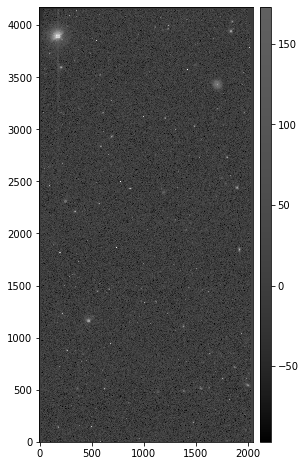

In [10]:
plt.figure()                        #create a matplotlib.pyplot figure
display = afwDisplay.Display()      #get an alias to the lsst.afw.display.Display() method
display.scale('asinh', 'zscale')    #set the image stretch algorithm and range
display.mtv(calexp.image)           #load the image into the display
plt.show()                          #show the corresponding pyplot figure

Often you may want to plot two images side-by-side. This can be done by creating matplotlib subplots.

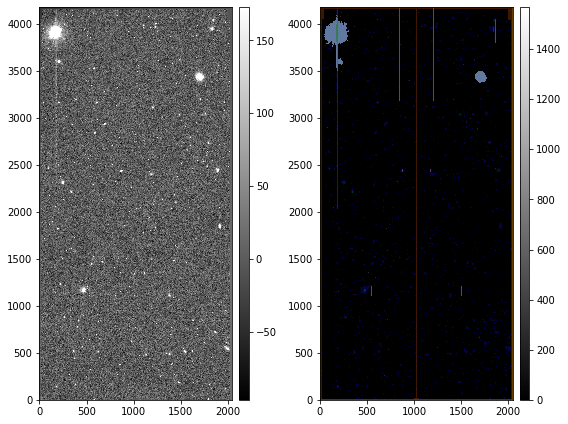

In [11]:
fig,ax = plt.subplots(1,2)

plt.sca(ax[0]) # set the first axes as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp.image)

plt.sca(ax[1]) # set the second axes as current
display2 = afwDisplay.Display(frame=fig)
display2.mtv(calexp.mask)

plt.tight_layout()

It is also possible to plot the mask on top of the image using the `calexp.maskedImage`.

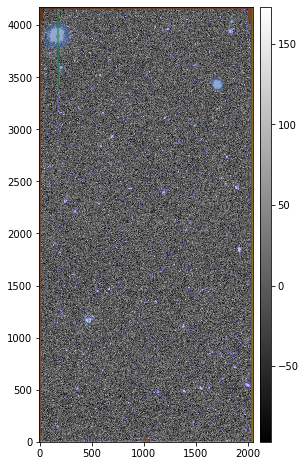

In [12]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(calexp.maskedImage)

**Congrats!** We've plotted an image using `lsst.afw.display`!

## **Step 3.2) Use AFWDisplay to Visualize the Image and Mask Plane**

The `calexp` returned by the butler contains more than just the image pixel values (see the [calexp tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). One other component is the mask plane associated with the image. `AFWDisplay` provides a nice pre-packaged interface for overplotting the mask associated with an image. A mask is composed of a set of "mask planes", 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

We'll follow the same steps as above to display the image, but we'll add a few modifications

* We explicitly set the transparency of the overplotted mask (0 = transparent, 1 = opaque)
* We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e. all pixels associated with detected objects).
* We pass the full `calexp` object to `mtv` instead of just the image plane.

<Figure size 576x576 with 0 Axes>

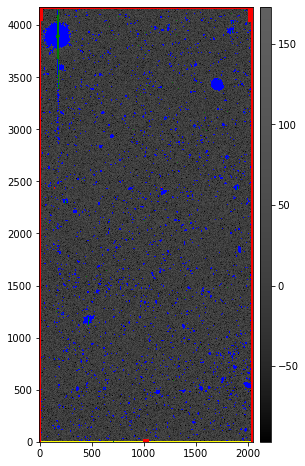

In [13]:
plt.figure()                                     #create a matplotlib.pyplot figure
afw_display = afwDisplay.Display()               #get an alias to the lsst.afw.display.Display() method
afw_display.scale('asinh', 'zscale')             #set the image stretch algorithm and range
afw_display.setMaskTransparency(0.4)             #set the transparency of the mask plane (1 = opaque)
afw_display.setMaskPlaneColor('DETECTED','blue') #set the color for a single plane in the mask
afw_display.mtv(calexp)                          #load the image and mask plane into the display
plt.show()                                       #show the corresponding pyplot figure

The `afw_display` object contains more information about the mask planes that can be accessed

In [14]:
print("Mask plane bit definitions:\n", afw_display.getMaskPlaneColor())  # Print the colors associated to each plane in the mask
print("\nMask plane methods:\n")
help(afw_display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a `dict`)
    
        Colors may be specified as any X11-compliant string (e.g. `"orchid"`), or by one
        of the following constants in `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore" (or `IGNORE`) then

## **Step 4) More Information about lsst.afw.display**

To get some more information about `lsst.afw.display`, we can print the method list to see what's available. The next cell will print `lsst.afw.display` methods to the screen.

In [15]:
method_list = [func for func in dir(display) if callable(getattr(display, func))]
print(method_list)

['Buffering', '_Buffering', '__class__', '__del__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'delAllDisplays', 'dot', 'erase', 'flush', 'getActiveCallbackKeys', 'getDefaultBackend', 'getDefaultFrame', 'getDisplay', 'getMaskPlaneColor', 'getMaskTransparency', 'incrDefaultFrame', 'interact', 'line', 'maskColorGenerator', 'mtv', 'pan', 'scale', 'setCallback', 'setDefaultBackend', 'setDefaultFrame', 'setDefaultImageColormap', 'setDefaultMaskPlaneColor', 'setDefaultMaskTransparency', 'setImageColormap', 'setMaskPlaneColor', 'setMaskTransparency', 'show', 'zoom']


If you'd like to learn more about any given function, please see the [`lsst.afw.display` source code](https://github.com/lsst/afw/tree/master/python/lsst/afw/display).

You can also read the API documentation about the above functions using the Jupyter notebook `help()` function:

In [16]:
help(display.scale)

Help on method scale in module lsst.afw.display.interface:

scale(algorithm, min, max=None, unit=None, *args, **kwargs) method of lsst.afw.display.interface.Display instance
    Set the range of the scaling from DN in the image to the image display
    
    Parameters
    ----------
    algorithm : `str`
        Desired scaling (e.g. "linear" or "asinh")
    min
        Minimum value, or "minmax" or "zscale"
    max
        Maximum value (must be `None` for minmax|zscale)
    unit
        Units for min and max (e.g. Percent, Absolute, Sigma; `None` if min==minmax|zscale)
    *args
        Optional arguments to the backend
    **kwargs
        Optional keyword arguments to the backend



In [17]:
help(display.mtv)

Help on method mtv in module lsst.afw.display.interface:

mtv(data, title='', wcs=None) method of lsst.afw.display.interface.Display instance
    Display an `~lsst.afw.image.Image` or `~lsst.afw.image.Mask` on a display
    
    Notes
    -----
    Historical note: the name "mtv" comes from Jim Gunn's forth imageprocessing
    system, Mirella (named after Mirella Freni); The "m" stands for Mirella.



### **Further Documentation**

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://github.com/lsst/afw/blob/master/doc/lsst.afw.image/indexing-conventions.rst)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [The `pipelines.lsst.io` Getting Started on Image Display website.](https://pipelines.lsst.io/getting-started/display.html)